In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, MaxPooling1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import compute_class_weight
from sklearn.utils import class_weight
from tensorflow.keras.metrics import Precision, Recall, AUC, SparseCategoricalAccuracy
import time
import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import movmus as mm
import movmus2 as mm2

import json

## LOADING Model and EMG data

In [2]:
model_name = 'BASE_TASK_CONTEXT_MODEL_6_no_shape'
model_folder = '.\\MODELS_TC'
plot_folder = '.\\PLOTS_TC'

In [6]:
model_name = 'BASE_SUBJ_CONTEXT_MODEL_4'
model_folder = '.\\MODELS_SC'
plot_folder = '.\\PLOTS_SC'

In [3]:
model = mm.load_model(model_folder, model_name)


Loading model from .\MODELS_TC\BASE_TASK_CONTEXT_MODEL_6_no_shape.keras
Num Layers: 15
----
----
Layer: emg_input
{
    "batch_shape": [
        null,
        1000,
        7
    ],
    "dtype": "float32",
    "sparse": false,
    "name": "emg_input"
}
----
----
Layer: conv1d_4
{
    "name": "conv1d_4",
    "trainable": true,
    "dtype": {
        "module": "keras",
        "class_name": "DTypePolicy",
        "config": {
            "name": "float32"
        },
        "registered_name": null
    },
    "filters": 16,
    "kernel_size": [
        5
    ],
    "strides": [
        1
    ],
    "padding": "valid",
    "data_format": "channels_last",
    "dilation_rate": [
        1
    ],
    "groups": 1,
    "activation": "relu",
    "use_bias": true,
    "kernel_initializer": {
        "module": "keras.initializers",
        "class_name": "GlorotUniform",
        "config": {
            "seed": null
        },
        "registered_name": null
    },
    "bias_initializer": {
        "

In [4]:
train_data, val_data, test_data = mm.load_data_npz('EMG_1000_data.npz')

shape of training data: (2720, 1000, 7)
shape of validation data: (502, 1000, 7)
shape of test data: (661, 1000, 7)


In [5]:
train_labels, val_labels, test_labels = mm.load_data_npz('labels.npz')

shape of training data: (2720, 2)
shape of validation data: (502, 2)
shape of test data: (661, 2)


## task context data

In [7]:
validation_context_data = mm.load_metadata_npz('task_context_val.npz')
test_context_data = mm.load_metadata_npz('task_context_test.npz')
validation_context_data = validation_context_data.iloc[:, 1:]
test_context_data = test_context_data.iloc[:, 1:]
print(test_context_data.shape, validation_context_data.shape)

(661, 24) (502, 24)


## task context data (no shape)

In [6]:
validation_context_data = mm.load_metadata_npz('task_no_shape_context_val.npz')
test_context_data = mm.load_metadata_npz('task_no_shape_context_test.npz')
print(test_context_data.shape, validation_context_data.shape)

(661, 6) (502, 6)


## subject context data


In [10]:
validation_context_data = mm.load_metadata_npz('subject_context_val.npz')
validation_context_data = validation_context_data.iloc[:, 1:]
test_context_data = mm.load_metadata_npz('subject_context_test.npz')
test_context_data = test_context_data.iloc[:, 1:]
print(test_context_data.shape, validation_context_data.shape)

(661, 5) (502, 5)


## EVALUATION

In [7]:
test_context_data = test_context_data.to_numpy()

In [8]:
evaluation = model.evaluate([test_data, test_context_data], test_labels, verbose=0)
print(evaluation)

[0.18904584646224976, 0.9379727840423584, 0.9379727840423584, 0.9379727840423584, 0.9762818217277527]


In [9]:
print(model.metrics_names)

['loss', 'compile_metrics']


In [10]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix

y_pred_probs = model.predict([test_data, test_context_data])  
y_pred = np.argmax(y_pred_probs, axis=1) 

y_true = np.argmax(test_labels, axis=1)  
print(y_pred.shape, y_true.shape, test_labels.shape)
# Calcular métricas adicionales
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
print(f'Loss: {evaluation[0]}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')

print(classification_report(y_true, y_pred))

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(661,) (661,) (661, 2)
Loss: 0.18904584646224976
Precision: 0.9552238805970149
Recall: 0.9248554913294798
Accuracy: 0.9379727685325264
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       315
           1       0.96      0.92      0.94       346

    accuracy                           0.94       661
   macro avg       0.94      0.94      0.94       661
weighted avg       0.94      0.94      0.94       661



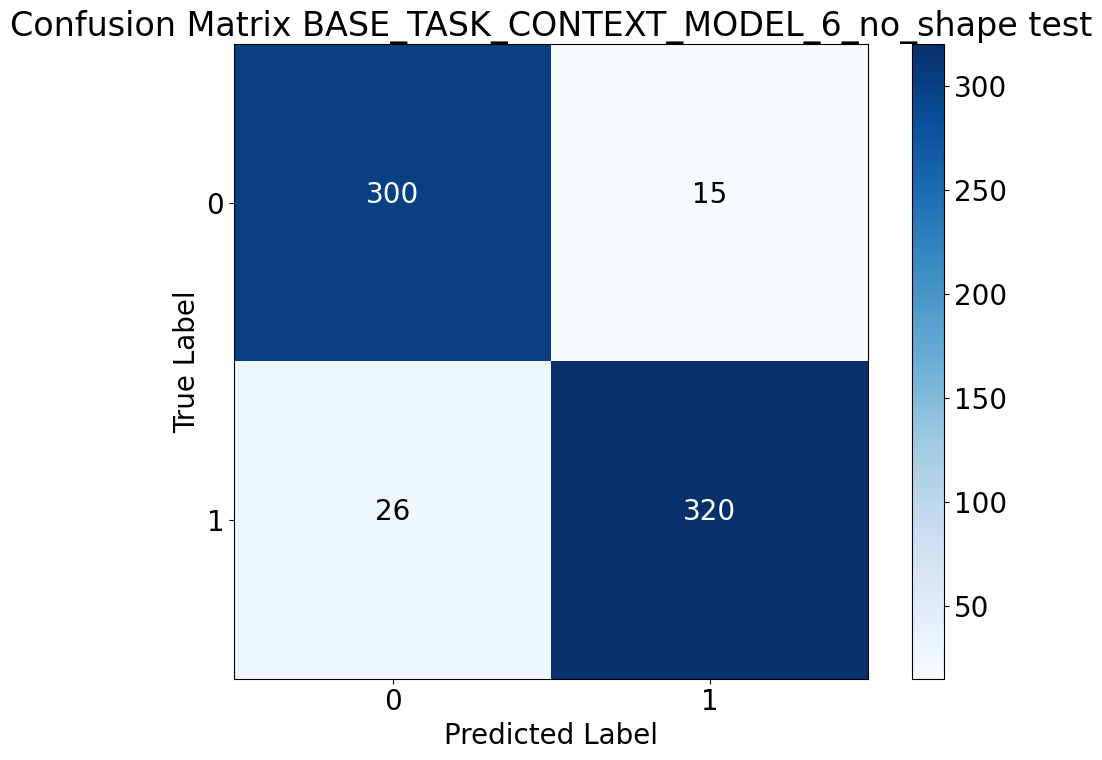

In [12]:
plt.rcParams.update({'font.size': 20})  # You can change the number to make it bigger/smaller

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
cmap = plt.cm.Blues
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion Matrix ' + model_name + ' test')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_true)))  # this adapts to the number of classes dynamically
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

# Labeling the axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations inside the squares
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.savefig(f'{plot_folder}\\CM_{model_name}_test.png')

plt.show()


## LOSS STUDY (FOR TASK HYBRID MODELS)

### reload the context data depending on model

In [12]:
test_context_data = mm.load_metadata_npz('task_no_shape_test_id.npz')
print(test_context_data.shape)

(661, 7)


In [ ]:
test_context_data = mm.load_metadata_npz('subject_context_test.npz')
test_context_data = test_context_data.iloc[:, 1:]
print(test_context_data.shape)

In [ ]:
test_context_data = mm.load_metadata_npz('task_context_test.npz')
#test_context_data = test_context_data.iloc[:, 1:]
print(test_context_data.shape)

In [13]:
test_context_data.head(5)

,ID,WEIGHT,SPAN_1,SPAN_2,TASK_HEIGHT_1.0,TASK_HEIGHT_2.0,TASK_HEIGHT_3.0
452,459.0,461.5,75.0,0.0,1.0,0.0,0.0
453,461.0,915.0,100.0,0.0,1.0,0.0,0.0
454,462.0,915.0,100.0,0.0,0.0,1.0,0.0
455,463.0,713.0,74.0,0.0,1.0,0.0,0.0
456,464.0,713.0,74.0,0.0,0.0,1.0,0.0


### analysis of misclassifications

In [14]:
# Find indices of misclassified samples
misclassified_indices = np.where(y_pred != y_true)[0]

# Number of misclassified samples
num_misclassified = len(misclassified_indices)
print(f'Number of misclassified samples: {num_misclassified}')

Number of misclassified samples: 41


In [15]:
misclassified_metadata = test_context_data.iloc[misclassified_indices]
test_ids = mm.get_ids(test_context_data)
print(len(test_ids))
missclassified_ids = mm.get_ids(misclassified_metadata)
print(len(missclassified_ids))

661
41


In [16]:
tc_shape_miss_ids = [756.0, 758.0, 759.0, 760.0, 761.0, 773.0, 775.0, 784.0, 942.0, 946.0, 961.0, 969.0, 971.0, 973.0, 1686.0, 1953.0, 1971.0, 2721.0, 2723.0, 2881.0, 2902.0, 3119.0, 3121.0, 3123.0, 3241.0, 3243.0]
print(len(tc_shape_miss_ids))

26


In [17]:
all_ids_present = all(id in missclassified_ids for id in tc_shape_miss_ids)
print(all_ids_present)

False


In [18]:
ids_not_in_missclassified = list(set(tc_shape_miss_ids) - set(missclassified_ids))
ids_not_in_missclassified

[1953.0, 961.0, 942.0, 3121.0, 946.0, 1971.0, 756.0]

In [19]:
common_ids = set(tc_shape_miss_ids).intersection(set(missclassified_ids))
common_ids = sorted(list(common_ids))
common_ids

[758.0,
 759.0,
 760.0,
 761.0,
 773.0,
 775.0,
 784.0,
 969.0,
 971.0,
 973.0,
 1686.0,
 2721.0,
 2723.0,
 2881.0,
 2902.0,
 3119.0,
 3123.0,
 3241.0,
 3243.0]

In [20]:
df = pd.read_parquet('TFM_METADATA_FINAL.parquet')
print(df.shape)
metadata_test = mm.filter_by_ids(test_ids, df)
metadata_error_test = mm.filter_by_ids(missclassified_ids, df)
print(metadata_test.shape, metadata_error_test.shape)

(3883, 23)
(661, 23) (41, 23)


In [21]:
metadata_error_test

,ID,PARTICIPANT,T,ET,datasize,PRODUCT_DH,WEIGHT,SPAN_1,SPAN_2,SHAPE_SPAN_1,...,GRASP_DH,ORI_PRODUCT_DH,ACTION_DH,TASK_HEIGHT,GENDER,AGE,HL,FOREARM,HEIGHT,new_datasize
718,732.0,9.0,104.0,13.0,1121.0,3.0,713.0,74.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,21.0,173.0,250.0,169.0,1121
735,749.0,9.0,112.0,64.0,947.0,9.0,965.0,77.0,30.0,1.0,...,1.0,1.0,1.0,2.0,1.0,21.0,173.0,250.0,169.0,947
744,758.0,9.0,117.0,91.0,1068.0,14.0,2073.0,30.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,21.0,173.0,250.0,169.0,1068
745,759.0,9.0,117.0,94.0,982.0,14.0,2073.0,30.0,0.0,1.0,...,1.0,1.0,1.0,2.0,1.0,21.0,173.0,250.0,169.0,982
746,760.0,9.0,118.0,97.0,1107.0,15.0,2891.0,30.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,21.0,173.0,250.0,169.0,1107
747,761.0,9.0,118.0,100.0,946.0,15.0,2891.0,30.0,0.0,1.0,...,1.0,1.0,1.0,2.0,1.0,21.0,173.0,250.0,169.0,946
750,764.0,9.0,121.0,111.0,1491.0,3.0,713.0,74.0,0.0,1.0,...,1.0,1.0,1.0,2.0,1.0,21.0,173.0,250.0,169.0,1491
753,767.0,9.0,124.0,123.0,1452.0,6.0,502.0,60.0,32.0,1.0,...,1.0,1.0,1.0,2.0,1.0,21.0,173.0,250.0,169.0,1452
757,771.0,9.0,128.0,139.0,2746.0,10.0,508.0,66.0,38.0,1.0,...,1.0,1.0,1.0,2.0,1.0,21.0,173.0,250.0,169.0,2385
759,773.0,9.0,130.0,147.0,1872.0,13.0,1550.0,22.5,42.0,1.0,...,1.0,1.0,1.0,2.0,1.0,21.0,173.0,250.0,169.0,1761


#### grouping by task and et (task context)

In [50]:
error_test_task_et = metadata_error_test.groupby(['T', 'ET']).agg(
    count=('ID', 'size'),  # Count the number of samples
    ids=('ID', lambda x: list(x))  # Aggregate IDs as a list
).reset_index().sort_values(by='count', ascending=False)
metadata_test_task_et = metadata_test.groupby(['T', 'ET']).agg(
    count=('ID', 'size'),  # Count the number of samples
    ids=('ID', lambda x: list(x))  # Aggregate IDs as a list
).reset_index().sort_values(by='count', ascending=False)

In [56]:
error_test_task_et = error_test_task_et.head(10).sort_values(by='T', ascending=True)
error_test_task_et

,T,ET,count,ids
14,140.0,182.0,3,"[969.0, 1713.0, 1980.0]"
15,141.0,185.0,2,"[784.0, 1981.0]"
17,144.0,194.0,3,"[787.0, 973.0, 1984.0]"
18,176.0,323.0,2,"[1188.0, 1746.0]"
19,177.0,327.0,2,"[817.0, 1747.0]"
21,207.0,376.0,3,"[2721.0, 2881.0, 3241.0]"
22,208.0,382.0,3,"[2723.0, 3123.0, 3243.0]"
25,229.0,457.0,1,[2744.0]
26,234.0,468.0,1,[2909.0]
27,302.0,471.0,2,"[3820.0, 3898.0]"


In [57]:
metadata_test_task_et = metadata_test_task_et[metadata_test_task_et['T'].isin(error_test_task_et['T'])]
metadata_test_task_et = metadata_test_task_et[metadata_test_task_et['ET'].isin(error_test_task_et['ET'])]
metadata_test_task_et.sort_values(by='T', ascending=True)

,T,ET,count,ids
55,140.0,182.0,6,"[504.0, 783.0, 969.0, 1155.0, 1713.0, 1980.0]"
56,141.0,185.0,6,"[505.0, 784.0, 970.0, 1156.0, 1714.0, 1981.0]"
59,144.0,194.0,6,"[508.0, 787.0, 973.0, 1159.0, 1717.0, 1984.0]"
88,176.0,323.0,6,"[537.0, 816.0, 1002.0, 1188.0, 1746.0, 2013.0]"
89,177.0,327.0,6,"[538.0, 817.0, 1003.0, 1189.0, 1747.0, 2014.0]"
103,207.0,376.0,6,"[2601.0, 2721.0, 2801.0, 2881.0, 3121.0, 3241.0]"
105,208.0,382.0,6,"[2603.0, 2723.0, 2803.0, 2883.0, 3123.0, 3243.0]"
115,229.0,457.0,1,[2744.0]
117,234.0,468.0,1,[2909.0]
118,302.0,471.0,4,"[3625.0, 3820.0, 3898.0, 4132.0]"


In [24]:
print(metadata_test_task_et[(metadata_test_task_et['T'] == 140.0) & (metadata_test_task_et['ET'] == 182.0)])
print(metadata_test_task_et[(metadata_test_task_et['T'] == 208.0) & (metadata_test_task_et['ET'] == 382.0)])
print(metadata_test_task_et[(metadata_test_task_et['T'] == 207.0) & (metadata_test_task_et['ET'] == 376.0)])
print(metadata_test_task_et[(metadata_test_task_et['T'] == 144.0) & (metadata_test_task_et['ET'] == 194.0)])
print(metadata_test_task_et[(metadata_test_task_et['T'] == 141.0) & (metadata_test_task_et['ET'] == 185.0)])
print(metadata_test_task_et[(metadata_test_task_et['T'] == 302.0) & (metadata_test_task_et['ET'] == 471.0)])
print(metadata_test_task_et[(metadata_test_task_et['T'] == 177.0) & (metadata_test_task_et['ET'] == 327.0)])
print(metadata_test_task_et[(metadata_test_task_et['T'] == 176.0) & (metadata_test_task_et['ET'] == 323.0)])


        T     ET  count                                            ids
55  140.0  182.0      6  [504.0, 783.0, 969.0, 1155.0, 1713.0, 1980.0]
         T     ET  count                                               ids
105  208.0  382.0      6  [2603.0, 2723.0, 2803.0, 2883.0, 3123.0, 3243.0]
         T     ET  count                                               ids
103  207.0  376.0      6  [2601.0, 2721.0, 2801.0, 2881.0, 3121.0, 3241.0]
        T     ET  count                                            ids
59  144.0  194.0      6  [508.0, 787.0, 973.0, 1159.0, 1717.0, 1984.0]
        T     ET  count                                            ids
56  141.0  185.0      6  [505.0, 784.0, 970.0, 1156.0, 1714.0, 1981.0]
         T     ET  count                               ids
118  302.0  471.0      4  [3625.0, 3820.0, 3898.0, 4132.0]
        T     ET  count                                             ids
89  177.0  327.0      6  [538.0, 817.0, 1003.0, 1189.0, 1747.0, 2014.0]
        T   

of the 6 cases in all of the test data with this specific T and ET combination, 3 were misclassified 

for the grouped with 2 misclassifications, they were also out of 6 total samples

#### grouping by participant

In [25]:
error_participant = metadata_error_test.groupby(['PARTICIPANT', 'GENDER']).agg(
    count=('ID', 'size'),  # Count the number of samples
    ids=('ID', lambda x: list(x))  # Aggregate IDs as a list
).reset_index().sort_values(by='count', ascending=False)
error_participant

,PARTICIPANT,GENDER,count,ids
0,9.0,1.0,17,"[732.0, 749.0, 758.0, 759.0, 760.0, 761.0, 764..."
3,19.0,1.0,7,"[1686.0, 1713.0, 1746.0, 1747.0, 3119.0, 3123...."
1,11.0,0.0,5,"[962.0, 963.0, 969.0, 971.0, 973.0]"
6,29.0,1.0,4,"[2881.0, 2902.0, 2909.0, 3898.0]"
4,22.0,0.0,3,"[1980.0, 1981.0, 1984.0]"
5,28.0,0.0,2,"[3820.0, 3822.0]"
7,30.0,0.0,2,"[3241.0, 3243.0]"
2,13.0,1.0,1,[1188.0]


In [41]:
metadata_participant = metadata_test.groupby(['PARTICIPANT', 'GENDER']).agg(
    count=('ID', 'size'),  # Count the number of samples
    ids=('ID', lambda x: list(x))  # Aggregate IDs as a list
).reset_index().sort_values(by='count', ascending=False)
metadata_participant = metadata_participant[metadata_participant['PARTICIPANT'].isin(error_participant['PARTICIPANT'])]

metadata_participant

,PARTICIPANT,GENDER,count,ids
4,19.0,1.0,112,"[1658.0, 1659.0, 1660.0, 1661.0, 1662.0, 1663...."
1,9.0,1.0,111,"[728.0, 729.0, 730.0, 731.0, 732.0, 733.0, 734..."
3,13.0,1.0,93,"[1100.0, 1101.0, 1102.0, 1103.0, 1104.0, 1105...."
2,11.0,0.0,92,"[914.0, 915.0, 916.0, 917.0, 918.0, 919.0, 920..."
5,22.0,0.0,83,"[1933.0, 1935.0, 1936.0, 1938.0, 1939.0, 1940...."
9,30.0,0.0,23,"[3231.0, 3233.0, 3235.0, 3237.0, 3241.0, 3243...."
7,28.0,0.0,22,"[2791.0, 2793.0, 2795.0, 2797.0, 2799.0, 2801...."
8,29.0,1.0,20,"[2871.0, 2873.0, 2875.0, 2877.0, 2879.0, 2881...."


#### grouping by product

In [59]:
error_product = metadata_error_test.groupby(['PRODUCT_DH', 'WEIGHT']).agg(
    count=('ID', 'size'),  # Count the number of samples
    ids=('ID', lambda x: list(x))  # Aggregate IDs as a list
).reset_index().sort_values(by='count', ascending=False)
error_product = error_product.head(10)
error_product = error_product.sort_values(by='PRODUCT_DH', ascending=True)
error_product

,PRODUCT_DH,WEIGHT,count,ids
0,3.0,713.0,2,"[732.0, 764.0]"
4,13.0,1550.0,3,"[773.0, 1686.0, 3119.0]"
5,14.0,2073.0,5,"[758.0, 759.0, 2721.0, 2881.0, 3241.0]"
6,15.0,2891.0,7,"[760.0, 761.0, 775.0, 2723.0, 3123.0, 3130.0, ..."
9,20.0,88.0,3,"[969.0, 1713.0, 1980.0]"
10,21.0,0.0,4,"[784.0, 1981.0, 2744.0, 2902.0]"
12,24.0,79.0,3,"[787.0, 973.0, 1984.0]"
13,43.0,1002.0,2,"[1188.0, 1746.0]"
14,44.0,750.0,2,"[817.0, 1747.0]"
16,63.0,440.0,2,"[3820.0, 3898.0]"


In [63]:
metadata_product = metadata_test.groupby(['PRODUCT_DH', 'WEIGHT']).size().reset_index(name='count').sort_values(by='count', ascending=False)
metadata_product = metadata_product[metadata_product['PRODUCT_DH'].isin(error_product['PRODUCT_DH'])]

metadata_product.sort_values(by='PRODUCT_DH', ascending=True)

,PRODUCT_DH,WEIGHT,count
2,3.0,713.0,16
12,13.0,1550.0,24
13,14.0,2073.0,25
14,15.0,2891.0,26
19,20.0,88.0,6
20,21.0,0.0,9
23,24.0,79.0,6
33,43.0,1002.0,6
34,44.0,750.0,6
46,63.0,440.0,4


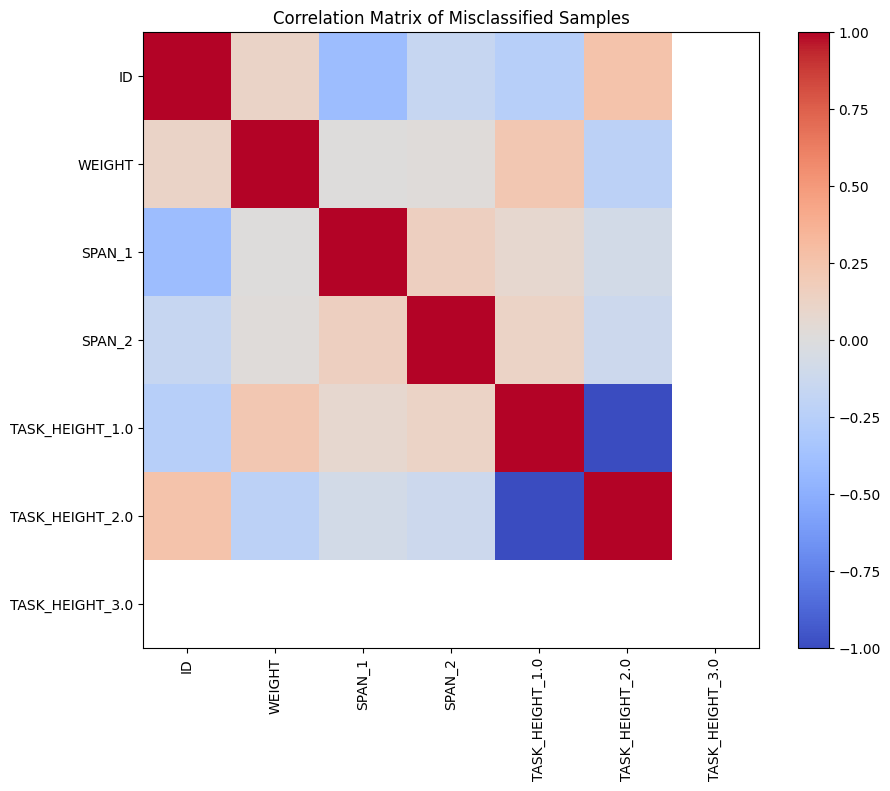

In [29]:
import numpy as np

# Compute the correlation matrix for misclassified samples
corr_matrix = misclassified_metadata.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()

# Add labels
plt.xticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns)

# Add title
plt.title('Correlation Matrix of Misclassified Samples')

# Show plot
plt.show()

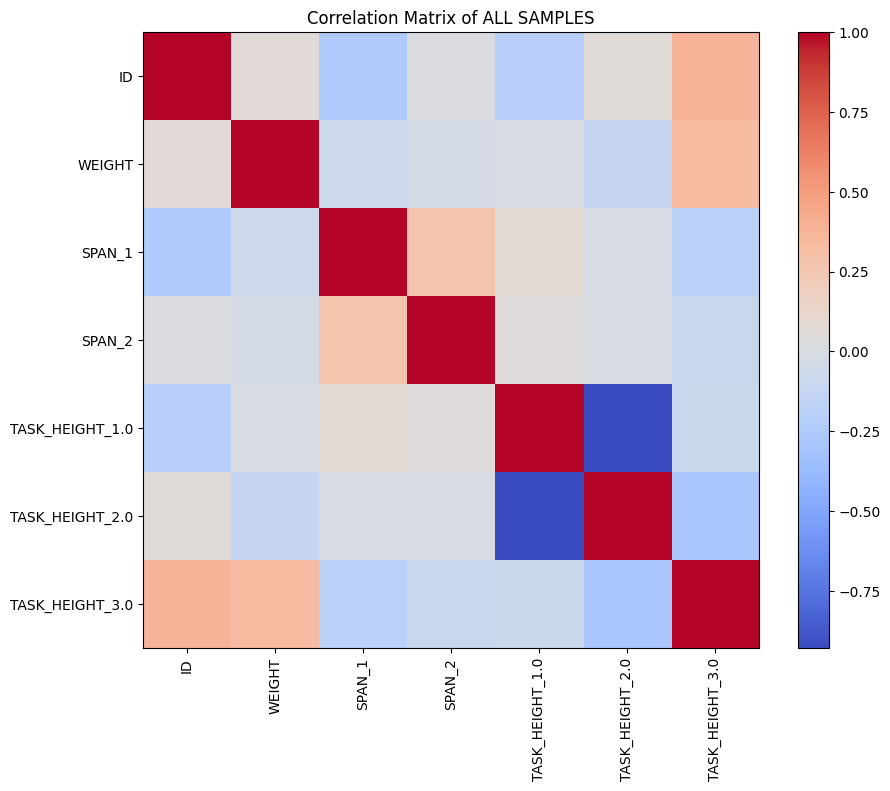

In [30]:
import numpy as np

# Compute the correlation matrix for misclassified samples
corr_matrix = test_context_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()

# Add labels
plt.xticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns)

# Add title
plt.title('Correlation Matrix of ALL SAMPLES')

# Show plot
plt.show()

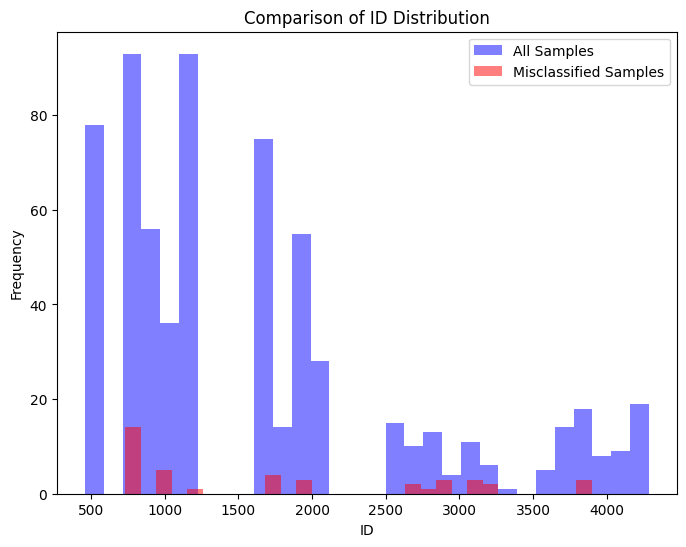

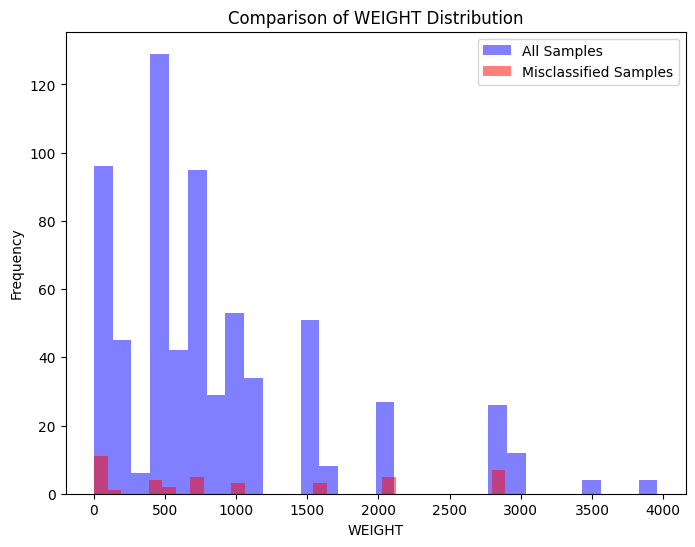

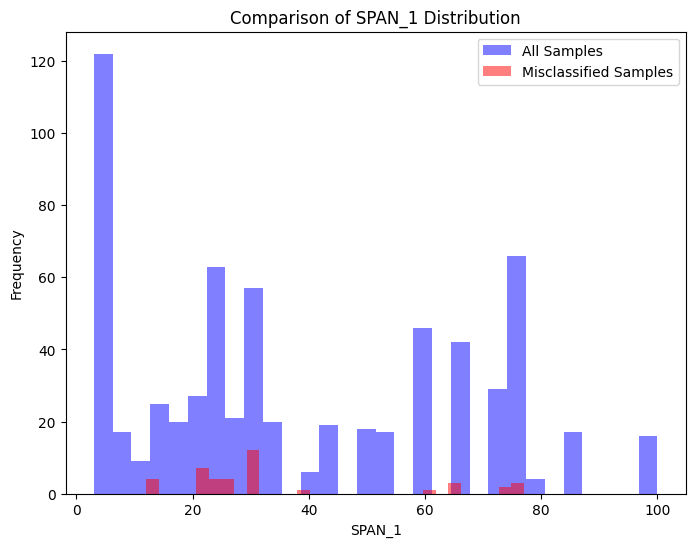

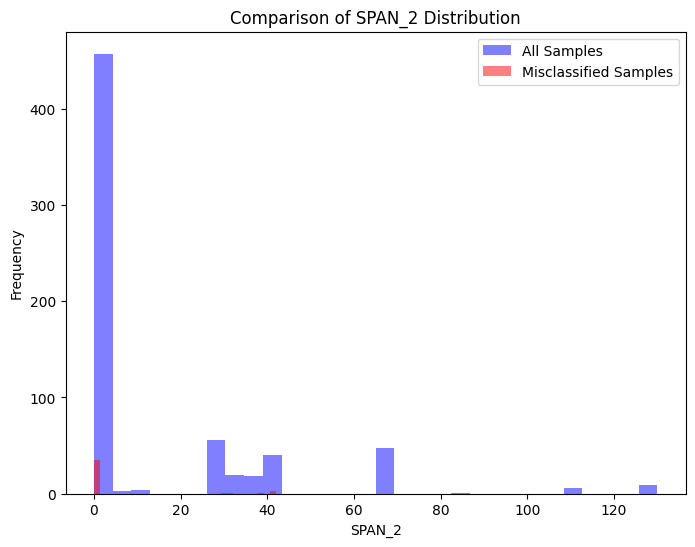

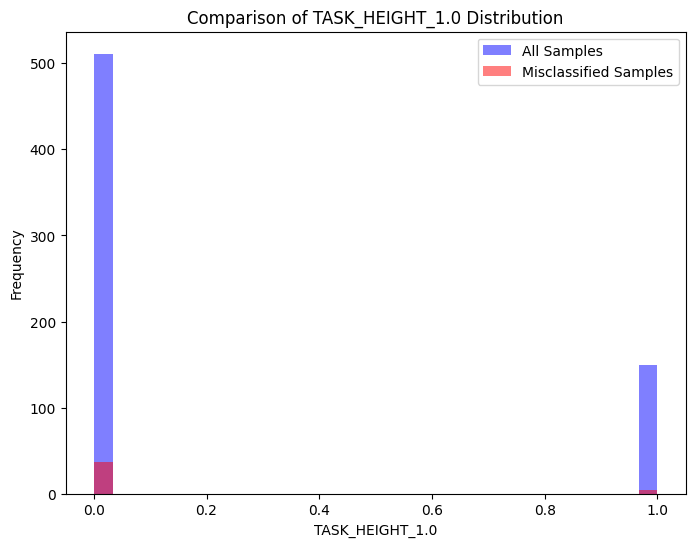

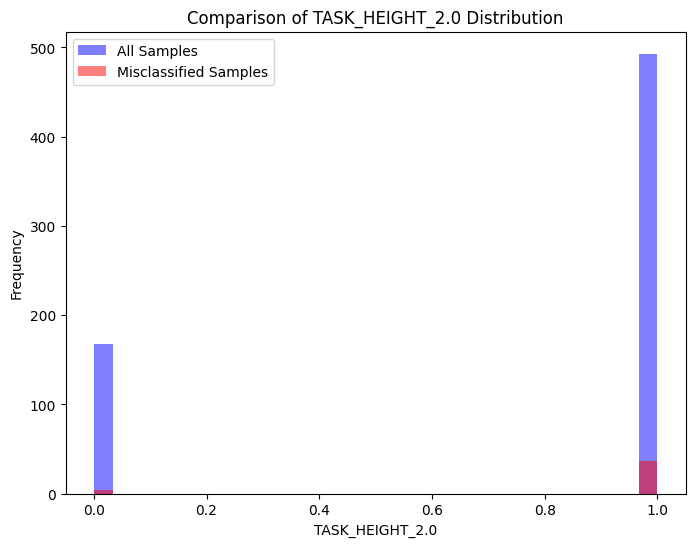

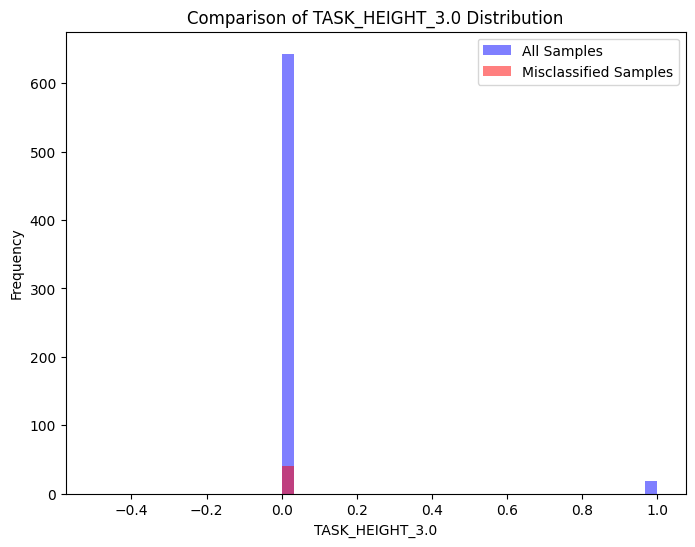

In [31]:
for feature in test_context_data.columns:
    plt.figure(figsize=(8, 6))
    
    # Histogram for all samples
    plt.hist(test_context_data[feature], bins=30, color='blue', alpha=0.5, label='All Samples')
    
    # Histogram for misclassified samples
    plt.hist(misclassified_metadata[feature], bins=30, color='red', alpha=0.5, label='Misclassified Samples')
    
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Comparison of {feature} Distribution')
    plt.legend()
    plt.show()